# Анализ и совершенствование датасета загруженного из базы данных посредством SQL, с целью выявления наименее прибыльных рейсов в зимнее время из г. Анапа.

In [471]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [472]:
df = pd.read_csv('airlines_anapa.csv')

In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            127 non-null    int64  
 1   departure            127 non-null    object 
 2   arrival              127 non-null    object 
 3   departure_airport    127 non-null    object 
 4   arrival_airport      127 non-null    object 
 5   aircraft_code        127 non-null    object 
 6   economy_sold         118 non-null    float64
 7   comfort_sold         0 non-null      float64
 8   business_sold        118 non-null    float64
 9   price_eco_sold       118 non-null    float64
 10  price_bus_sold       118 non-null    float64
 11  price_total          118 non-null    float64
 12  aircraft_model       127 non-null    object 
 13  aircraft_range       127 non-null    int64  
 14  amount_eco_seats     127 non-null    int64  
 15  amount_bus_seats     127 non-null    int

Видим один столбец содержит только Nan значения, удалим его. Также видим что часть столбцов имеет 9 Nan значениц, это все столбцы содержащие значения о проданных билетах, видимо о части рейсов нет данных по проданным билетам.

In [474]:
df = df.drop(columns=['comfort_sold'])

In [475]:
df.sample(10)

,flight_id,departure,arrival,departure_airport,arrival_airport,aircraft_code,economy_sold,business_sold,price_eco_sold,price_bus_sold,price_total,aircraft_model,aircraft_range,amount_eco_seats,amount_bus_seats,total_seats,total_booking_price,arrival_city,airport_longitude,airport_latitude,anapa_long,anapa_lat
121,136758,2017-01-12T09:25:00Z,2017-01-12T10:15:00Z,AAQ,EGO,SU9,85.0,12.0,538500.0,226800.0,765300.0,Sukhoi Superjet-100,3000,85,12,97,4638600.0,Belgorod,36.590099,50.643799,37.347301,45.002102
98,136436,2017-01-26T10:05:00Z,2017-01-26T11:45:00Z,AAQ,SVO,733,112.0,12.0,1372400.0,439200.0,1811600.0,Boeing 737-300,4200,118,12,130,6990900.0,Moscow,37.414600,55.972599,37.347301,45.002102
78,136452,2017-02-17T10:05:00Z,2017-02-17T11:45:00Z,AAQ,SVO,733,98.0,11.0,1200400.0,402600.0,1603000.0,Boeing 737-300,4200,118,12,130,7062300.0,Moscow,37.414600,55.972599,37.347301,45.002102
10,136540,2017-01-17T06:10:00Z,2017-01-17T11:15:00Z,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102
48,136953,2017-02-27T09:25:00Z,2017-02-27T10:15:00Z,AAQ,EGO,SU9,85.0,12.0,538500.0,226800.0,765300.0,Sukhoi Superjet-100,3000,85,12,97,4719200.0,Belgorod,36.590099,50.643799,37.347301,45.002102
59,136172,2017-01-15T10:05:00Z,2017-01-15T11:45:00Z,AAQ,SVO,733,99.0,11.0,1215000.0,402600.0,1617600.0,Boeing 737-300,4200,118,12,130,6593200.0,Moscow,37.414600,55.972599,37.347301,45.002102
22,136605,2017-02-15T09:25:00Z,2017-02-15T10:15:00Z,AAQ,EGO,SU9,85.0,12.0,538500.0,226800.0,765300.0,Sukhoi Superjet-100,3000,85,12,97,5066800.0,Belgorod,36.590099,50.643799,37.347301,45.002102
40,136654,2017-01-19T09:25:00Z,2017-01-19T10:15:00Z,AAQ,EGO,SU9,84.0,12.0,532200.0,226800.0,759000.0,Sukhoi Superjet-100,3000,85,12,97,4569700.0,Belgorod,36.590099,50.643799,37.347301,45.002102
124,136855,2017-01-11T09:25:00Z,2017-01-11T10:15:00Z,AAQ,EGO,SU9,75.0,12.0,475500.0,226800.0,702300.0,Sukhoi Superjet-100,3000,85,12,97,4491100.0,Belgorod,36.590099,50.643799,37.347301,45.002102
118,136586,2017-01-10T09:25:00Z,2017-01-10T10:15:00Z,AAQ,EGO,SU9,84.0,12.0,532200.0,226800.0,759000.0,Sukhoi Superjet-100,3000,85,12,97,5530500.0,Belgorod,36.590099,50.643799,37.347301,45.002102


Видим что отсутствуют значения по рейсу в Новокузнецк, скорее всего именно по рейсам в Новокузнецк и отсутсвует информация о проданных билетах.
Далее преобразуем столбцы с датами вылета и прилёта в формат datetime, чтобы в дальнейшем было удобнее работать.

In [476]:
df['departure'] = df['departure'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df['arrival'] = df['arrival'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))

Создадим признак показывающий в какой день недели состоялся рейс.

In [477]:
def days(x):
    return x.strftime('%A')

In [478]:
df['days'] = df['departure'].apply(days)

Посмотрим на информацию по всем рейсам в Новокузнецк.

In [479]:
df.query('arrival_city == "Novokuznetsk"')

,flight_id,departure,arrival,departure_airport,arrival_airport,aircraft_code,economy_sold,business_sold,price_eco_sold,price_bus_sold,price_total,aircraft_model,aircraft_range,amount_eco_seats,amount_bus_seats,total_seats,total_booking_price,arrival_city,airport_longitude,airport_latitude,anapa_long,anapa_lat,days
8,136511,2017-02-21 06:10:00,2017-02-21 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
9,136523,2017-01-10 06:10:00,2017-01-10 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
10,136540,2017-01-17 06:10:00,2017-01-17 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
11,136546,2017-01-03 06:10:00,2017-01-03 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
38,136560,2017-01-24 06:10:00,2017-01-24 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
79,136513,2017-02-28 06:10:00,2017-02-28 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
80,136514,2017-02-07 06:10:00,2017-02-07 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
81,136567,2017-02-14 06:10:00,2017-02-14 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday
117,136544,2017-01-31 06:10:00,2017-01-31 11:15:00,AAQ,NOZ,733,NaN,NaN,NaN,NaN,NaN,Boeing 737-300,4200,118,12,130,NaN,Novokuznetsk,86.877197,53.811401,37.347301,45.002102,Tuesday


Действительно, оказывается что по всем рейсам в Новокузнецк нет информации о билетах. Также замечаем что рейсы есть только по вторникам.

Далее дополним датасет данными, которые невозможно получить на основе имеющихся.

# Дополнительные данные, которые отсутсвовали в базе
## Расход топлива
Для оценки расхода топлива в пассажирских самолетах приоритетным показателем является грамм/пасс-км, т.к. позволяет точнее рассчитать расход в зависимости от кол-ва пассажиров. Однако такой показатель есть не для каждого самолета, поэтому другим, более универсальным, является показатель кг/час. Он показывает сколько кг топлива расходует самолет на крейсерской скорости в час, является менее точным т.к. не учитывает загруженность самолета, однако представлен в характеристике для каждого судна. 
В наших данных при перевозках используются две модели самолетов: boeing и sukhoi. Для боинга есть все данные по расходу топлива, а для российской модели только расход кг/час. Таким образом я принял решение посчитать для боинга расход по 2 показателям для каждого рейса и взять среднее, а для "сухого" только по кг/час.
## Цена топлива
Цены на авиатопливо отличаются в зависимости от региона и аэропорта. Данные получены на сайте росавиации по состоянию на февраль 2017 года для аэропорта Анапы. 2017 год взят т.к. анализируются рейсы 2017 года.

In [480]:
fuel_per_pas = {'boeing': 26, 'sukhoi': None}  # gramm per passenger per 1 km
fuel_per_hour = {'boeing': 2.4, 'sukhoi': 1.7}  # ton per hour
fuel_price = 49700  # Цена за тонну топлива в аэропорту Анапы в 2017г

# Рассчёт дополнительных показателей на основе найденых новых 
## Длина перелёта
Для рассчета длины перелёта применяется функция, принимающая данные широты и долготы двух точек,и учитывает радиус земли. Найдена при помощи гугл.

In [481]:
def distanceBetweenKm(lat1, lon1, lat2, lon2):
    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)

    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2)**2 + math.sin(dLon/2)**2 * \
        math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return round(c * 6371, 0)  # multiply by 100k to get distance in cm

In [482]:
df['flight_distance'] = df.apply(
    lambda x: distanceBetweenKm(x['anapa_lat'], x['anapa_long'], x['airport_latitude'], x['airport_longitude']), axis=1)

## Стоимость топлива на перелёт
На определенный рейс, заправляя самолет учитывают:
1. Топливо необходимое для преодоления расстояния до аэропорта назначении. 
2. Топливо для полета от аэропорта назначение до запасного аэродрома.
3. Горючее для ожидания посадки в течение 30 минут на малой высоте.
4. Надбавка 5% на непредвиденные обстоятельства.

На основании этих данных принято решение, в функции для рассчёта стоимости топлива на рейс, к количеству топлива необходимого непосредственно на перелёт из одного аэропорта в другой, прибавлять еще 15% на все остальные случаи.
В процессе исследования данных было обнаружено, что по перелётам в Новокузнецк отсутсвуют данные о проданных билетах. Было решено за основу взять среднюю заполняемость других рейсов по вторникам, чтобы рассчитать расход на основе двух формул.
Для рейсов на судне "боинг" стоимость рассчитывется по двум показателям ("кг/час", "гр/пасс-км") и берется среднее, как говорилось выше. 
Для рейсов на российском судне "суперджет сухой" стоимость рассчитывалась только по показателю "кг/час".

In [483]:
df['flight_lasts_min'] = df['arrival']-df['departure']
df['flight_lasts_min'] = df['flight_lasts_min'].apply(lambda x: x.seconds/60)

In [484]:
df['perc_sold'] = (df['economy_sold'] +
                   df['business_sold']) / df['total_seats']
# Средняя заполняемость самолетов по вторникам
mean_perc_sold_tuesday = df.query('days=="Tuesday"')['perc_sold'].mean()
df['perc_sold'] = df['perc_sold'].apply(
    lambda x: mean_perc_sold_tuesday if pd.isna(x) else x)

In [485]:
def count_costs_flight(x):
    if x['aircraft_code'] == '733':
        if x['arrival_airport'] == 'NOZ':
            v = x['perc_sold'] * x['total_seats'] * x['flight_distance'] * \
                fuel_per_pas['boeing']/1000000 * \
                fuel_price  # расход топлива по показателю гр/пасс-км
            # расход топлива по показателю кг/час
            n = (fuel_per_hour['boeing']/60) * \
                x['flight_lasts_min'] * fuel_price
            return round(((n+v)/2)*1.15, 0)
        else:
            p = (x['economy_sold']+x['business_sold']) * \
                x['flight_distance'] * fuel_per_pas['boeing']/1000000 * fuel_price
            h = (fuel_per_hour['boeing']/60) * \
                x['flight_lasts_min'] * fuel_price
            return round(((p + h)/2)*1.15, 0)
    if x['aircraft_code'] == 'SU9':
        s = (fuel_per_hour['sukhoi']/60) * x['flight_lasts_min'] * fuel_price
        return round(s*1.15, 0)

In [486]:
df['flight_costs'] = df.apply((lambda x: count_costs_flight(x)), axis=1)

# Прибыльность
Рассчитаем прибыль по каждому рейсу как разницу между ценой всех проданных билетов и стоимости заправки топлива на перелет

In [487]:
df['revenue'] = df['price_total'] - df['flight_costs']

# Визуализация
Далее построим несколько графиков для более наглядного анализа прибыльных и менее прибыльных рейсов

In [488]:
df_M = df.query('arrival_city == "Moscow"').sort_values(by=['departure'])
df_B = df.query('arrival_city == "Belgorod"').sort_values(by=['departure'])
df_N = df.query('arrival_city == "Novokuznetsk"').sort_values(by=['departure'])

## Прибыльность в зависимости от города назначения

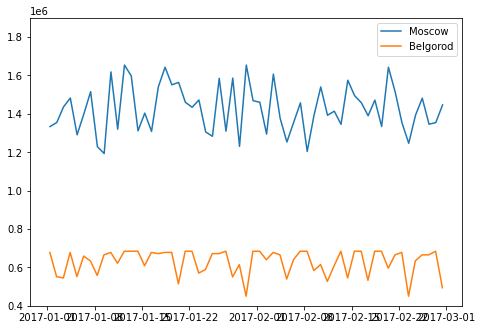

In [489]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0.4e+6, 1.9e+6)
axes.plot(df_M['departure'], df_M['revenue'], label='Moscow')
axes.plot(df_B['departure'], df_B['revenue'], label='Belgorod')
#axes.plot(df_N['departure'], df_N['revenue'], label = 'Novokuznetsk')
axes.legend(loc=1)

Очевидно, что Московское направление на порядок прибыльнее Белгорода. На данном графике представлено только 2 города: Москва и Белгород т.к. данных по билетам в Новокузнецк нет, принято решение не использовать искаженные данные, возможно кто-то другой сможет их найти и достроить верный график.

# Далее график расходов на рейсы в разные города

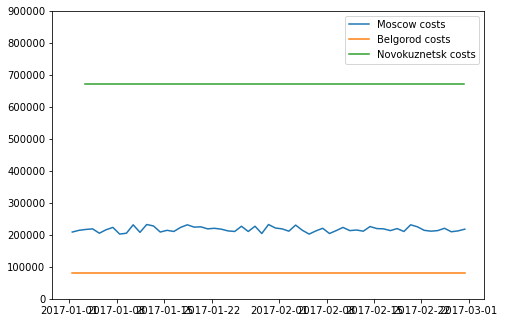

In [490]:
fig_cost = plt.figure()
axes_cost = fig_cost.add_axes([0, 0, 1, 1])
axes_cost.set_ylim(0, 9e+5)
axes_cost.plot(df_M['departure'], df_M['flight_costs'], label='Moscow costs')
axes_cost.plot(df_B['departure'], df_B['flight_costs'], label='Belgorod costs')
axes_cost.plot(df_N['departure'], df_N['flight_costs'],
               label='Novokuznetsk costs')
axes_cost.legend(loc=1)

Видим что рейсы в Новокузнецк с большим отрывом самые дорогие. Полёты в белгород дешевле Москвы в 2 раза и в 7 раз дешевле Новокузнецка. Уже тут можно предположить что Новокузнецк вряд ли будет самым прибыльным. 

# Заполняемость рейсов по городам в %

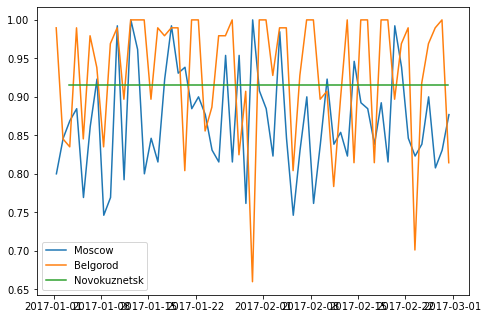

In [491]:
fig_perc = plt.figure()
axes_perc = fig_perc.add_axes([0, 0, 1, 1])
axes_perc.plot(df_M['departure'], df_M['perc_sold'], label='Moscow')
axes_perc.plot(df_B['departure'], df_B['perc_sold'], label='Belgorod')
axes_perc.plot(df_N['departure'], df_N['perc_sold'], label='Novokuznetsk')
axes_perc.legend(loc=3)

Все рейсы заполнены в пределах 75-100%, за исключением пары выбросов в Московском направлении. Новокузнецк мы заполнили сами на оснвое двух других городов, отсюда прямая линия.

Попробуем визуализировать эти же данные иначе...

In [492]:
perc_mean_M = df.query('arrival_city == "Moscow"')['perc_sold'].mean()
perc_mean_B = df.query('arrival_city == "Belgorod"')['perc_sold'].mean()

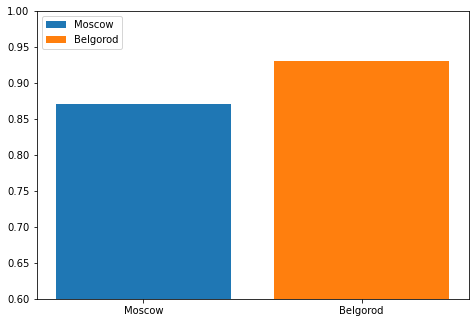

In [493]:
fig_perc_mn = plt.figure()
axes_perc_mn = fig_perc_mn.add_axes([0, 0, 1, 1])
axes_perc_mn.bar(x=df.query('arrival_city == "Moscow"')[
                 'arrival_city'], height=perc_mean_M, label='Moscow')
axes_perc_mn.bar(x=df.query('arrival_city == "Belgorod"')['arrival_city'], height=perc_mean_B,
                 label='Belgorod')
axes_perc_mn.set_ylim(0.6, 1)
axes_perc_mn.legend(loc=2)

Тут уже видно, что в среднем заполняемость на рейсах в Белгород лучше чем на Москву.

Далее посмотрим как заполняемость отличается по дням недели.

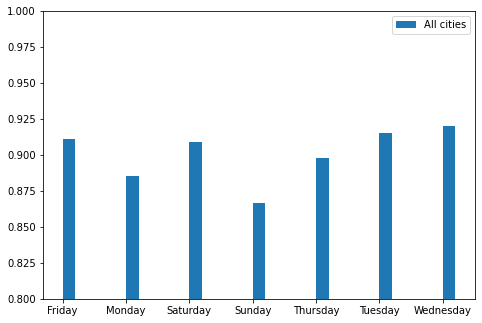

In [494]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
axes_days.set_ylim(0.8, 1)
axes_days.bar(x=df.query('arrival_city not in ("Novokuznetsk")').groupby(by=['days'])['perc_sold'].mean().index, height=df.query('arrival_city not in ("Novokuznetsk")').groupby(by=['days'])['perc_sold'].mean().values,
              width=0.2, align='edge', label='All cities')
axes_days.legend(loc=1)

Воскресенье и понедельник являются самыми незаполнеными, в остальные дни заполненность рейсов примерно равная. Но это для всех рейсов, интересно какая ситуация для каждого отдельного направления.

## Заполненность рейсов в Москву по дням недели, в %

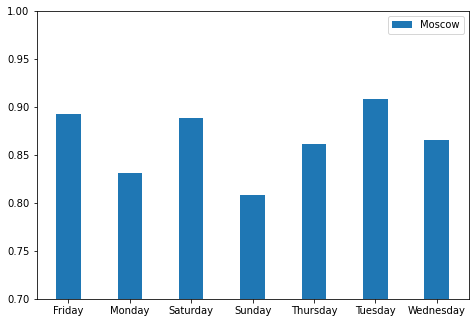

In [495]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
axes_days.set_ylim(0.7, 1)
axes_days.bar(x=df.query('arrival_city == "Moscow"').groupby(by=['days'])['perc_sold'].median().index, height=df.query('arrival_city == "Moscow"').groupby(by=['days'])['perc_sold'].median().values,
              width=0.4, label='Moscow')
axes_days.legend(loc=1)

Видим, что в воскресенье и понедельник заполняемость самолета хуже всего, а вот по вторникам наоборот, наивысшая.

## Заполняемость рейсов в Белгород по дням недели, в %

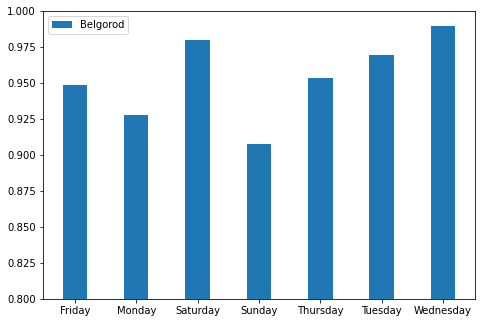

In [496]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
axes_days.set_ylim(0.8, 1)
axes_days.bar(x=df.query('arrival_city == "Belgorod"').groupby(by=['days'])['perc_sold'].median().index, height=df.query('arrival_city == "Belgorod"').groupby(by=['days'])['perc_sold'].median().values,
              width=0.4, label='Belgorod')
axes_days.legend(loc=2)

На рейсах в Белгород самым незаполненным днем является также воскресенье, хотя в этот день заполняемость все равно составляет около 90%. А вот по четвергам и субботам в Белгород наоборот летает почти полный самолет - более 97%.

## Дальше посмотрим как заполняемость влияет на прибыльность рейсов по дням, в RUB

Первым рассмотрим Московское направление.

In [497]:
rev_mos_d = df.query('arrival_city=="Moscow"').groupby(
    by=['days'])['revenue'].median()
rev_belg_d = df.query('arrival_city=="Belgorod"').groupby(
    by=['days'])['revenue'].median()

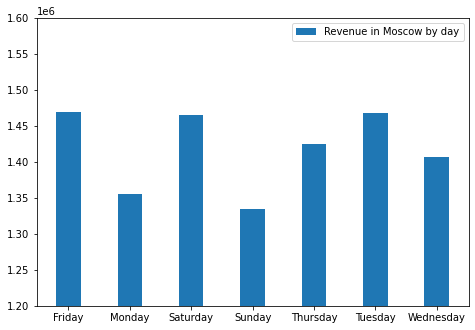

In [498]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
axes_days.set_ylim(1.2e+6, 1.6e+6)
axes_days.bar(x=rev_mos_d.index, height=rev_mos_d.values,
              width=0.4, label='Revenue in Moscow by day')
axes_days.legend(loc=1)

Как и ожидалось, менее заполненные дни оказались и менее прибыльными. По воскресеньям и понедельникам прибыль на рейсах в Москву на 100-150 тыс.руб. меньше чем в другие дни.

# Белгород

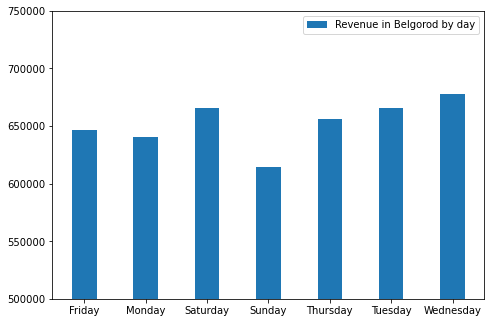

In [500]:
fig_days = plt.figure()
axes_days = fig_days.add_axes([0, 0, 1, 1])
axes_days.set_ylim(5e+5, 7.5e+5)
axes_days.bar(x=rev_belg_d.index, height=rev_belg_d.values,
              width=0.4, label='Revenue in Belgorod by day')
axes_days.legend(loc=1)

В Белгород тоже самым неприбыльным днем является воскресенье, хоть и не так ярко выраженно как в Москву.

# Вывод

Таким образом, рассмотрев преимущественно направление на Москву и Белгород, можно сделать вывод, что воскресные рейсы в обоих направлениях являются самыми неприбыльными. В Москву также заметно неприбыльным является рейс по понедельникам. По Новокузнецку какой-то то вывод сделать сложно т.к. отсутсвуют данные по ценам на билеты и по их количеству. Опираясь лишь на примерные данный о расходах на рейс до Новокузнецка могу предположить что он может являться кандидатом на закрытие в зимнее время для компании.
Если давать конкретную рекомендацию по закрытию рейсов, исходя из представленного датасета, то это конечно воскресный рейс в Белгород. Однако допускаю что статья расходов по рейсам в Москву гораздо выше, чем расходы на топливо, поэтому и прибыльность по ним в реальности может быть гораздо ниже, а учитывая довольно низкую заполняемость рейсов в Москву по воскресеньям и понедельникам, настоятельно рекомендую руководству компании задуматься о целесообразности полетов в эти дни.

In [513]:
df.query('arrival_city=="Moscow" and days in ("Monday")')['flight_id']

1     136130
21    136464
32    136226
36    136458
50    136266
52    136403
62    136282
93    136293
94    136322
Name: flight_id, dtype: int64

In [508]:
df.query('arrival_city=="Belgorod"').groupby(
    by=['days'])['revenue'].median().mean()

652251.4285714285